In [ ]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

PROJ = "My Drive/" 
PROJECT_PATH = join(ROOT, PROJ)

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import pickle

warnings.filterwarnings("ignore")

# Rading the Data

In [16]:
path_train = './data/V1.4_Training.csv'
path_test = './data/SubtaskA_EvaluationData.csv'

data_train = pd.read_csv(path_train, names = ['Id', 'Text', 'label'])
data_test = pd.read_csv(path_test, names = ['Id', 'Text', 'label'])

print('Shape of data_train:', data_train.shape)
print('Shape of data_test:', data_test.shape)

Shape of data_train: (8500, 3)
Shape of data_test: (833, 3)


In [3]:
data_train.head()

,Id,Text,label
0,663_3,"""Please enable removing language code from the...",1
1,663_4,"""Note: in your .csproj file, there is a Suppor...",0
2,664_1,"""Wich means the new version not fully replaced...",0
3,664_2,"""Some of my users will still receive the old x...",0
4,664_3,"""The store randomly gives the old xap or the n...",0


In [17]:
data_test.head()

,Id,Text,label
0,9566,This would enable live traffic aware apps.,X
1,9569,Please try other formatting like bold italics ...,X
2,9576,Since computers were invented to save time I s...,X
3,9577,Allow rearranging if the user wants to change ...,X
4,9579,Add SIMD instructions for better use of ARM NE...,X


# Functions for reading and writing a pickel file

In [5]:
# Save the object in pickel file
def save_obj(path, obj, name):
    with open(path + '/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Read the object from pickel file
def load_obj(path, name):
    with open(path + '/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Preprocessing the text data

Checking whether data contans missing value if it contans then remove it.

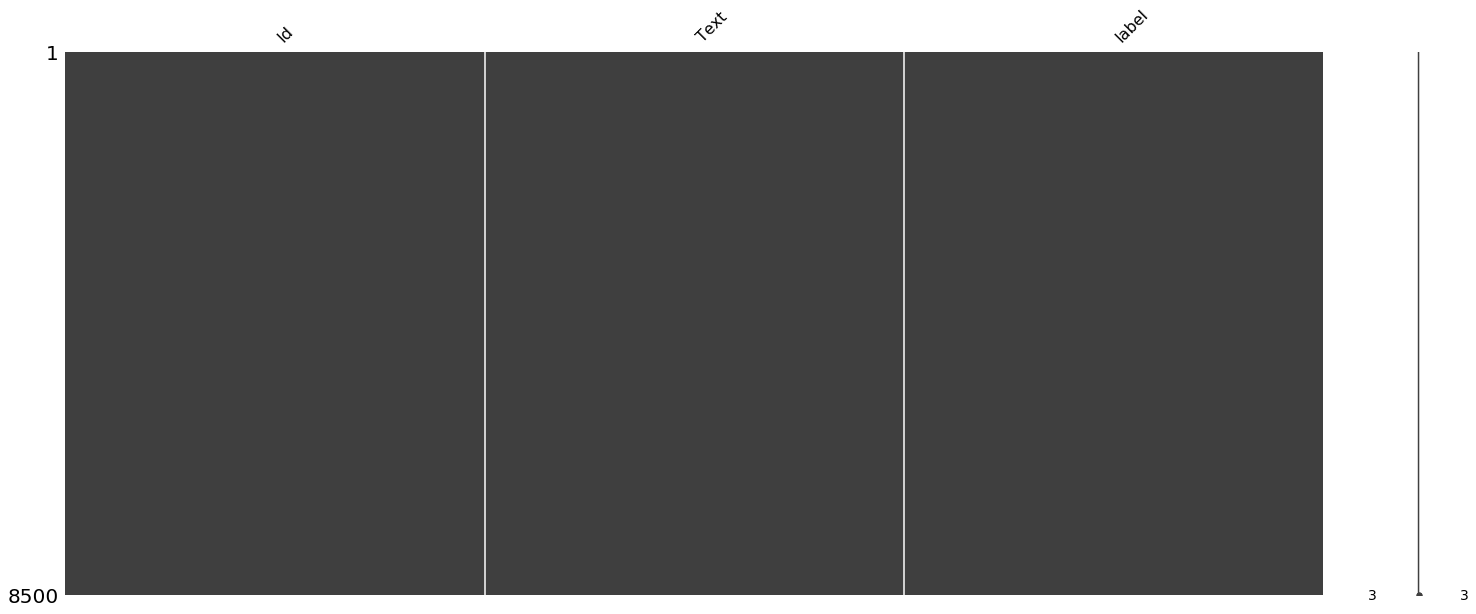

In [7]:
import missingno as msno

# Visualising missing values in the plots
msno.matrix(data_train)

data_train = data_train.dropna()

There is no missing value in data.

In [8]:
def preprocess(corpus):
    import nltk
    import re
    from tqdm import tqdm
    
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.stem import PorterStemmer
    
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    
    stop_words = set(stopwords.words('english'))
    
    for i in tqdm(range(len(corpus))):
        corpus[i] = re.sub('[^a-zA-Z0-9]', ' ', corpus[i]) # Removing non-alpha numeric characters.
        corpus[i] = corpus[i].lower() # Lowerig the cases of the letters.
        corpus[i] = nltk.word_tokenize(corpus[i]) # Tockenising the text.
        
        # Stemming + lemmatising + stopword removal
        #corpus[i] = [porter.stem(lemmatizer.lemmatize(word)) for word in corpus[i] if not word in stop_words]
        
        # Lemmatising the tockens.
        corpus[i] = [lemmatizer.lemmatize(word) for word in corpus[i] if not word in stop_words] 
        corpus[i] = ' '.join(corpus[i])
        
    return corpus        

In [9]:
data_train['Text'] = preprocess(data_train['Text'])
data_test['Text'] = preprocess(data_test['Text'])

100%|██████████| 833/833 [08:56<00:00,  2.04it/s]


In [12]:
save_obj('./data', data_train, 'data_train')
save_obj('./data', data_test, 'data_test')

In [ ]:
# data_train = load_obj('./data', 'data_train')
# data_test = load_obj('./data', 'data_test')

# Splitting the data into training set and test set

70:30 split of data

In [ ]:
from sklearn.model_selection import train_test_split

X, y, test = data_train['Text'], data_train['label'], data_test['Text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Featurising text

* Bag of word
* Tf-Idf vector
* Avearge word2vec
* TfIdf Weighted word2vec
* GLove
* Doc2vec

# Bag of word based vectorisation of documents

In [ ]:
def Bag_of_word_model(X_train, X_test):
    from sklearn.feature_extraction.text import CountVectorizer
    
    bow_model = CountVectorizer()
    X_train = bow_model.fit_transform(X_train)
    X_test = bow_model.transform(X_test)
    vocab = bow_model.get_feature_names()
    
    return X_train, X_test, Vocab

In [ ]:
X_train, X_test, Vocab = Bag_of_word(X_train, X_test)

# TfIdf based vectorisation of documents

In [ ]:
def tfidf_vectoriser_model(X_train, X_test):
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    tfidf_model = TfidfVectorizer()
    X_train = tfidf_model.fit_transform(X_train)
    X_test = tfidf_model.transform(X_test)
    vocab = tfidf_model.get_feature_names()
    
    return X_train, X_test, Vocab

In [ ]:
X_train, X_test, Vocab = tfidf_vectoriser_model(X_train, X_test)

# Average word2vec represenation of documents.
* Low dimension as comapred to bag-of-word and tfIDF vectors
* Retains the relationship between the words.

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Importing pretrained word2Vec model.
word2vec_model = KeyedVectors.load_word2vec_format(PROJECT_PATH + "/GoogleNews-vectors-negative300.bin", binary=True)
w2v_vocab = list(word2vec_model.wv.vocab)
    
def avg_w2v(corpus): 
    avg_w2v = []
    for doc in corpus:
        vec = np.zeros(300) # Google pretrained word2vec has 300 dimensions.
        doc = doc.split(' ')
        word_count = 0
        for t in doc:
            if t in w2v_vocab:
                vec += word2vec_model.wv[t] # Get vector representation of each word in word2vec model.
                word_count += 1

        if word_count != 0:
            vec = vec/word_count # Return avg word2vec for each document.
        avg_w2v.append(vec)

    return np.array(avg_w2v)

In [ ]:
X = avg_w2v(X)
test = avg_w2v(test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [ ]:
save_obj('./data', X, 'X')
save_obj('./data', test, 'test')

In [ ]:
# X = load_obj('./data','X')

# Xgboost Classifier
* XGboost = GBDT + row-sampling + column-smapling
* By using the row-sampling and column-sampling XGboost is able to take best qualities of Random forest

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameter = {'max_depth':[1, 2, 3, 4],
                   'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] }
clf = GridSearchCV(XGBClassifier(n_jobs=-1),
                  tuned_parameter, scoring='accuracy', n_jobs=-1)

train_the_classifier_and_analyse_the_test_results(clf, X_train, y_train, X_test, y_test)

print('\n', clf.best_estimator_)

# Final Submission

In [ ]:
data_test['label'] = y_pred

In [22]:
data = load_obj('./data', 'output')

In [23]:
data['Text'] = data_test['Text']

In [24]:
data.head()

,Id,Text,label
0,9566,This would enable live traffic aware apps.,1
1,9569,Please try other formatting like bold italics ...,1
2,9576,Since computers were invented to save time I s...,0
3,9577,Allow rearranging if the user wants to change ...,0
4,9579,Add SIMD instructions for better use of ARM NE...,0


In [25]:
data.to_csv('Ankur_Pandey.csv', sep=',', index=False, header=None)